## Project: A/B Testing, Hypothesis Prioritization

**Client:** Online Store

**Objective:** Prioritize hypotheses, launch A/B test, and analyze results.

**Research Object:** Final data from the conducted experiment on the online store website.

**Data for Analysis:** Information about hypotheses for prioritization, information about online store visitors, and the quantity and volume of their purchases.

**Research Process:**

- Data preprocessing;
- Prioritization of hypotheses using the ICE and RICE methods;
- Comparison of cumulative revenue between groups;
- Comparison of cumulative average order value;
- Graph depicting the relative change in cumulative average order value of Group B compared to Group A;
- Comparison of cumulative average number of orders per visitor;
- Graph depicting the relative change in cumulative average number of orders per visitor of Group B compared to Group A;
- Testing the statistical significance of differences in average order value;
- Testing the statistical significance of differences in average number of orders per visitor.

**Analysis Results:**

1. Hypothesis Prioritization.
   It is recommended to base the prioritization of hypotheses on the RICE method results. 

The top three hypotheses are:

- Add a subscription form to all main pages to collect customer email addresses for email newsletters;
- Add product recommendation blocks to the online store website to increase conversion and average order value;
- Add two new traffic acquisition channels to attract 30% more users.

2. A/B Test.

   Group B is recognized as the winner of the test, but solely based on the fact that the average number of orders in Group B is higher than in Group A by 16.9%. It is essential to note that, in terms of the average order value, Group B underperforms Group A by 2%.

   The unsatisfactory outcome of the experiment can be attributed to incorrect input data. Errors occurred during the division of orders between the groups, with overlapping orders constituting over 15% of the total revenue during the test period. Additionally, the lack of data on unique visitors hinders a proper comparison of the average number of orders for each group.

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import math as mth
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()

pd.set_option('display.max_colwidth', None)

Установка функций для обработки и анализа данных.

In [2]:
def data_check(df, num_cols=None, cat_cols=None, cat_cols_value=None):
    """
    The data_check function is designed to perform data validation on a DataFrame.
    
    Arguments:
    - df: pandas.DataFrame - the data table to be checked.
    - num_cols: list, optional - a list of numerical columns for calculating statistical metrics.
    - cat_cols: list, optional - a list of categorical columns for counting unique values.
    - cat_cols_value: list, optional - a list of categorical columns for displaying unique values.
    
    Displays information about the data in the table, including:
    - Total number of rows and columns in the table.
    - Number of duplicate rows.
    - Number of unique values for each categorical column (if the cat_cols parameter is provided).
    - Unique values for each categorical column (if the cat_cols_value parameter is provided).
    - Statistical metrics for numerical columns (if the num_cols parameter is provided).
    """
    print('Total number of rows in the table:', df.shape[0])
    print('Number of columns in the table:', df.shape[1])
    print('Duplicate rows:', df.duplicated().sum())
    print('-'*45)

    if cat_cols:
        print('Number of unique values in columns:\n')
        for col in cat_cols:
            print(f'{col}: {df[col].nunique()}')
    print('-'*45)

    if cat_cols_value:
        print('Unique values for categorical columns:\n')
        for col_v in cat_cols_value:
            print(f'{col_v}:\n{df[col_v].value_counts()}\n')
    print('-'*45)
    if num_cols:
        print('Statistical metrics for numerical columns:\n')
        print(df[num_cols].describe())

In [3]:
def table_info(df):
    """
    The table_info function is designed to check the number and data types of values in a table.

    Arguments:
    - df: pandas.DataFrame - the data table to be checked.

    Returns a pandas.DataFrame containing information about each column of the table:
    - 'name_columns': column names.
    - 'total': total number of non-null values in the column.
    - 'NaN': number of missing values (NaN) in the column.
    - 'types': data type of the column.
    - 'missing_ratio': percentage of missing values relative to the total number of values in the column.

    The resulting DataFrame is sorted by the 'missing_ratio' column in descending order.
    """
    table = pd.DataFrame({
        'total': df.count(),
        'NaN': df.isnull().sum(),
        'types': df.dtypes,
        'missing_ratio': ((df.isnull().sum() / df.shape[0])*100).round(2)})
    table = table.sort_values(by='missing_ratio', ascending=False)  # Sorting by the 'missing_ratio' column in descending order
    table = table.reset_index().rename(columns={'index': 'name_columns'})  # Adding a column with indexes
    return table

## Data preprocessing

**Loading data**

In [4]:
hypothesis, orders, visitors = (
    pd.read_csv('/Users/yuliamazur/ПИТОН/Принятие решений в бизнесе/hypothesis.csv'),  
    pd.read_csv('/Users/yuliamazur/ПИТОН/Принятие решений в бизнесе/orders.csv'),  
    pd.read_csv('/Users/yuliamazur/ПИТОН/Принятие решений в бизнесе/visitors.csv'),  
)

print('Hypothesis')
display(hypothesis)
print()
print('Orders')
display(orders.head())
print()
print('Visitors')
display(visitors.head())

Hypothesis


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5



Orders


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B



Visitors


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


**Data Description:**

**hypothesis.csv**

- `Hypothesis` - a brief description of the hypothesis;
- `Reach` - coverage of users on a 10-point scale;
- `Impact` - impact on users on a 10-point scale;
- `Confidence` - confidence in the hypothesis on a 10-point scale;
- `Efforts` - the cost of resources to test the hypothesis on a 10-point scale. The larger the Efforts value, the more expensive it is to test the hypothesis.

**orders.csv**
- `transactionId` — order identifier;
- `visitorId` - identifier of the user who made the order;
- `date` — date when the order was made;
- `revenue` — order revenue;
- `group` — the A/B test group that the order belongs to.

**visitors.csv**
- `date` — date;
- `group` — A/B test group;
- `visitors` - the number of users on the specified date in the specified A/B test group

In [5]:
# Convert column names to lower case
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = [name.replace('Id', '_id') for name in orders.columns]

display(hypothesis.columns)
orders.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [6]:
data_check(
    orders, 
    num_cols=['revenue'], 
    cat_cols=['date'], 
    cat_cols_value=['group']
)

Total number of rows in the table: 1197
Number of columns in the table: 5
Duplicate rows: 0
---------------------------------------------
Number of unique values in columns:

date: 31
---------------------------------------------
Unique values for categorical columns:

group:
B    640
A    557
Name: group, dtype: int64

---------------------------------------------
Statistical metrics for numerical columns:

            revenue
count  1.197000e+03
mean   8.348006e+03
std    3.919113e+04
min    5.000000e+01
25%    1.220000e+03
50%    2.978000e+03
75%    8.290000e+03
max    1.294500e+06


In [7]:
table_info(orders)

,name_columns,total,NaN,types,missing_ratio
0,transaction_id,1197,0,int64,0.0
1,visitor_id,1197,0,int64,0.0
2,date,1197,0,object,0.0
3,revenue,1197,0,int64,0.0
4,group,1197,0,object,0.0


`Notes`
- There is enough data in the orders table for correct analysis
- No passes, no duplicates
- The data types are mostly intended, with the exception of date

In [8]:
table_info(hypothesis)

,name_columns,total,NaN,types,missing_ratio
0,hypothesis,9,0,object,0.0
1,reach,9,0,int64,0.0
2,impact,9,0,int64,0.0
3,confidence,9,0,int64,0.0
4,efforts,9,0,int64,0.0


In [9]:
table_info(visitors)

,name_columns,total,NaN,types,missing_ratio
0,date,62,0,object,0.0
1,group,62,0,object,0.0
2,visitors,62,0,int64,0.0


In [10]:
# convert the dates in the visitors and orders tables to the date format.

visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

`Notes`
- At the stage of primary data preprocessing: the case of column names was corrected, data types with date were replaced from object to datetime. Checked tables for duplicates and gaps.

### Check tables for data correctness

Let's check for what period there is data.

In [11]:
print(visitors['date'].max())
print(visitors['date'].min())
print()
print(orders['date'].max())
print(orders['date'].min())

2019-08-31 00:00:00
2019-08-01 00:00:00

2019-08-31 00:00:00
2019-08-01 00:00:00


Data in two tables for one period - full August 2019.

Let's see how visitors and customer orders are divided into groups A and B.

Let's check the **visitors** table for missing values for the dates in the groups. It is necessary that for all dates from August 1 to August 31 there are visitors for group A and for group B.

In [12]:
idx = pd.MultiIndex.from_product([pd.date_range(start='2019-08-01', end='2019-08-31'), ['A', 'B']])

groups = visitors.groupby(['date', 'group']).count()
missing = groups.reindex(idx, fill_value=0)

# Проверяем, есть ли отсутствующие значения
if missing['visitors'].min() == 0:
    print('There are missing values:')
    print(missing[missing['visitors'] == 0])
else:
    print('No missing values')

No missing values


Let's check if the number of values in the groups corresponds to the total sum of values.

In [13]:
print('Number of rows per group A and B in visitors:\n', visitors['group'].value_counts())
print()
print('The sum of visitors per group A in visitors:', visitors[visitors['group']=='A']['visitors'].sum())
print('Sum of visitors per group B in visitors:', visitors[visitors['group']=='B']['visitors'].sum())
print('Total number of visitors visitors:', visitors['visitors'].sum())

Number of rows per group A and B in visitors:
 A    31
B    31
Name: group, dtype: int64

The sum of visitors per group A in visitors: 18736
Sum of visitors per group B in visitors: 18916
Total number of visitors visitors: 37652


`Notes`
- table `visitors` is correct for further analysis. There are no gaps in the dates, the total amount of visitors is equal to the sum of groups A and B.

Let's check the `orders` table to see if there is data for each date for each group.

In [14]:
idx_ = pd.MultiIndex.from_product([pd.date_range(start='2019-08-01', end='2019-08-31'), ['A', 'B']])

groups_ = orders.groupby(['date', 'group']).count()

missing_ = groups_.reindex(idx_, fill_value=0)
missing_
if missing_['revenue'].min() == 0:
    print('There are missing values:')
    print(missing_[missing_['revenue'] == 0])
else:
    print('No missing values')

No missing values


The orders table has a unique customer identifier - visitor_id. Ideally (if these are not offline stores), each group should correspond to a unique buyer, i.e. a buyer from group A should not be a buyer from group B. Let's check the data, the number of unique buyers for groups and compare with the total number in the table.

In [15]:
print('Number of unique customers per group A in orders:', orders[orders['group']=='A']['visitor_id'].nunique())
print('Number of unique buyers per group B in orders:', orders[orders['group']=='B']['visitor_id'].nunique())
print('Total Unique Buyers:', orders['visitor_id'].nunique())

Number of unique customers per group A in orders: 503
Number of unique buyers per group B in orders: 586
Total Unique Buyers: 1031


**Important!** The sum of unique customers in group A and group B is not equal to the number of unique customers in the table. The difference is 58 buyers. Let's find them.

In [16]:
# create two lists of uniques by group and merge them.
usersA = pd.DataFrame(orders.query('group == "A"')['visitor_id'].unique()).rename(columns={0: 'visitor_id'})
usersB = pd.DataFrame(orders.query('group == "B"')['visitor_id'].unique()).rename(columns={0: 'visitor_id'})

common_users = pd.merge(usersA, usersB, how='inner', on='visitor_id')
print('The number of buyers present in groups A and B at the same time:', len(common_users))

The number of buyers present in groups A and B at the same time: 58


Let's look at the amount of orders of these buyers and determine whether they need to be removed from the analysis.

In [17]:
print('The sum of orders of buyers in group A, who also have purchases in group B:', orders.query('group == "A" and visitor_id in @common_users.visitor_id')['revenue'].sum()) 
print('The sum of orders of buyers in group B, who also have purchases in group A:', orders.query('group == "B" and visitor_id in @common_users.visitor_id')['revenue'].sum()) 
print()
print('Total Orders for Crossing Buyers:', orders.query('visitor_id in @common_users.visitor_id')['revenue'].sum()) 
print('The total amount of orders in the orders table:', orders['revenue'].sum())

The sum of orders of buyers in group A, who also have purchases in group B: 720147
The sum of orders of buyers in group B, who also have purchases in group A: 838788

Total Orders for Crossing Buyers: 1558935
The total amount of orders in the orders table: 9992563


**Important!**

The amount of orders for overlapping buyers is more than 1.5 million rubles, which is more than 15% of the total revenue for the two test groups for the specified period. This can significantly affect the result of the A/B test analysis.

Theoretically, a visitor can make two purchases under the influence of the tested hypotheses. To make a decision to conduct an analysis on such data, additional information from marketers, etc. is needed.

Next, we check to see if these overlapping users made purchases on the same day. It is hard to imagine that this is possible without additional information about the data collection for the test.

In [18]:
similar = orders.query('visitor_id in @common_users.visitor_id').pivot_table(index=['visitor_id', 'date'], columns='group', values='revenue')
similar.tail(3)

group                        A        B
visitor_id date                        
4256040402 2019-08-27   1630.0      NaN
           2019-08-31   5170.0   1850.0
4266935830 2019-08-29  78990.0  78990.0

Some of the 58 overlapping buyers made purchases on the same day. In addition, we see that there are duplicates (the same purchase is taken into account for both A and B).

Let's see how these data will affect the test results. Let's create the orders_clean table without taking into account the intersecting values. Next, we will check the initial table orders and orders_clean separately.

In [19]:
# create a table without taking into account intersecting values
orders_clean = orders.query('visitor_id not in @common_users.visitor_id')

### Prioritization of hypotheses: ICE, RICE

Choosing hypotheses for testing.

In [20]:
hypothesis['ICE'] = round(hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'], 1)
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


`Notes`
- Leading the first five hypotheses. Compare with the RICE method, add a coverage metric.

In [21]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

In [22]:
hypothesis[['hypothesis', 'ICE', 'RICE']] = hypothesis[['hypothesis', 'ICE', 'RICE']].round({'ICE': 1, 'RICE': 1})
hypothesis[['hypothesis', 'ICE', 'RICE']].sort_values(by='RICE', ascending=False).style.background_gradient(cmap='PuRd', low=0, high=1, subset=['ICE', 'RICE']).format({'ICE': '{:.1f}', 'RICE': '{:.1f}'})

,hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0,3.0


`Notes`

The RICE method left the same hypotheses in the top five as shown by the ICE method, but changed their order. The reason is that the coverage metric had a strong impact on the ranking and positioned the hypotheses more correctly.

### A/B test analysis. Graph of cumulative revenue by groups.

Let's build a cumulativeData table based on orders and visitors. Table structure: each date in August 2019 will correspond to test group A or B and values ​​with the accumulation of the number of orders, the number of buyers, the amount of revenue, the number of visitors.

In [23]:
# sort orders by date and group, so each date will be assigned a group.
# For every unique day, there is an A and there is a B.
datesGroups = orders[['date','group']].drop_duplicates()

# create two tables based on orders and visitors with cumulative totals for datesGroups rows
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}),axis=1).sort_values(by=['date','group'])
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# combine ordersAggregated and visitorsAggregated
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(4)


,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294


**Important!**

Earlier we found out that the orders table contains duplicate orders by group, overlapping orders for the same customers. We created the orders_clean table by deleting the values of these buyers. In order not to clutter up the project, we will check the values for the orders_clean table in parallel in the copy of the notebook. If the values will significantly change the values of the original orders, then we will reflect this in this project.

### Chart of cumulative revenue by groups

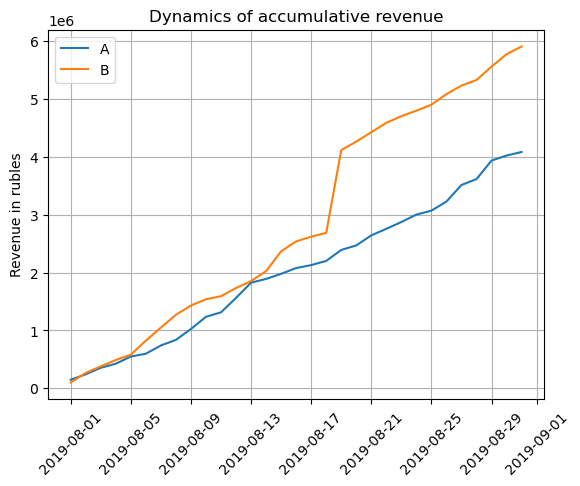

In [24]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Dynamics of accumulative revenue')
plt.ylabel("Revenue in rubles")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend();

`Notes`

- Group B dominates in terms of revenue. A confident separation from group A occurred on the 13th day of the test. A sharp jump in values on days 18-19 could have happened due to "outliers" - orders that were too expensive. Let's check this further.

### Graph of the cumulative average bill by groups

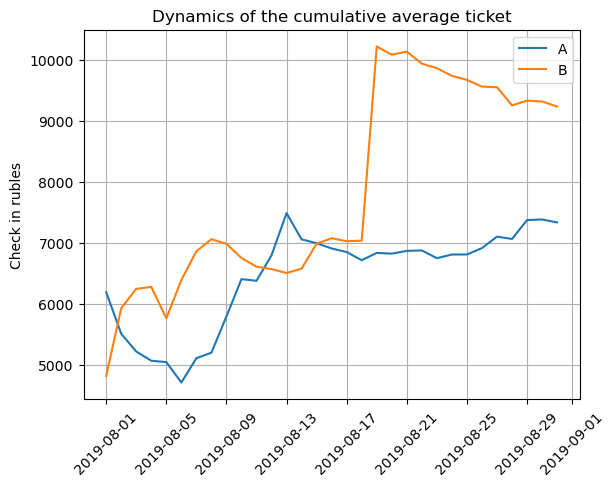

In [25]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Dynamics of the cumulative average ticket')
plt.ylabel("Check in rubles")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend();

`Notes`

- The average check "jumps" the first two weeks, then stabilizes. Outliers in group B prevent us from assessing the chart correctly. Without them, we would probably also see stabilization in this group.

### Graph of the relative change in the cumulative average check of group B to group A

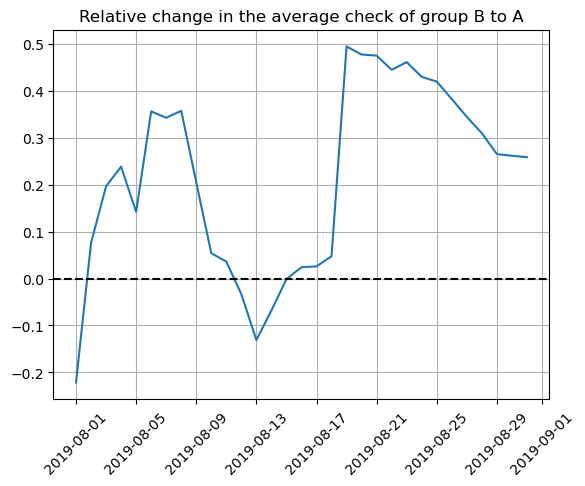

In [26]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--');
plt.title('Relative change in the average check of group B to A')
plt.xticks(rotation=45)
plt.grid(True)

`Notes`

- y = 0 is the base change point. If the graph is above this line, this means that group B has a higher average check than group A. If the graph is below the line, this means that group B has a lower average check than group A. Except for two points (beginning of the experiment and after two weeks from the start of the experiment), group B has a higher average check. It is difficult to estimate correctly due to outliers. Let's look at this further on data without anomalies.

### Graph of the cumulative average number of orders per visitor by group

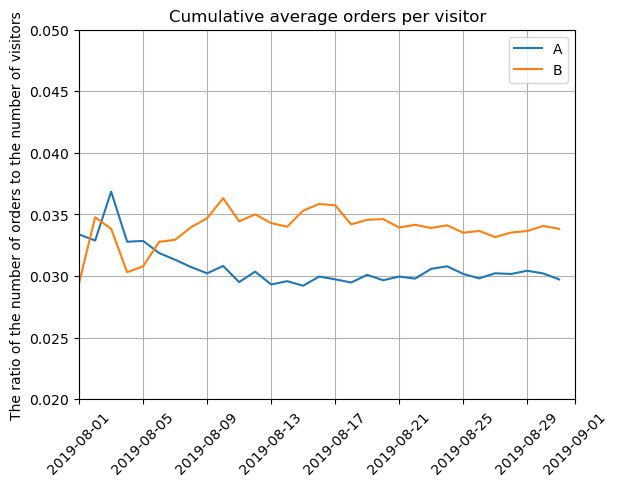

In [27]:
cumulativeData['avg'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.plot(cumulativeDataA['date'], cumulativeDataA['avg'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['avg'], label='B')
plt.title('Cumulative average orders per visitor')
plt.ylabel('The ratio of the number of orders to the number of visitors')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.axis(["2019-08-01", '2019-09-01', 0.02, 0.05]);

`Notes`

- The line of group B is above the line of group A, which means that group B had more orders per visitor than group A. At the beginning of the experiment, the values fluctuated, but by day 10 the situation leveled off. It's also important to remember that we don't have information about whether visitors are unique. In our case, the same person could be a visitor several times.

### Graph of the relative change in the cumulative average number of orders per visitor of group B to group A

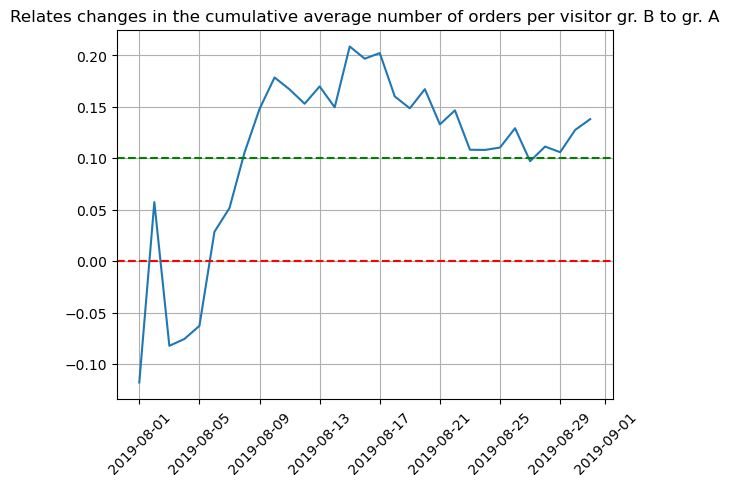

In [28]:
mergedCumulative_avg = cumulativeDataA[['date','avg']].merge(cumulativeDataB[['date','avg']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulative_avg['date'], mergedCumulative_avg['avgB']/mergedCumulative_avg['avgA']-1)
plt.xticks(rotation=45)
plt.grid(True)
plt.title('Relates changes in the cumulative average number of orders per visitor gr. B to gr. A')

plt.axhline(y=0, color='red', linestyle='--');
plt.axhline(y=0.10, color='green', linestyle='--');

`Notes`

- The relative growth of group B began with a negative value, then leveled off and continues to increase in the future.

- Group B growth is above 10% for most of the time, which may indicate that this growth is stable.

### Scatter plot of the number of orders by customers

Let's see how many orders per customer. Let's build a scatterplot and calculate the 95th and 99th percentiles. Let's group the data of the orders table by users and calculate the unique number of orders for each.

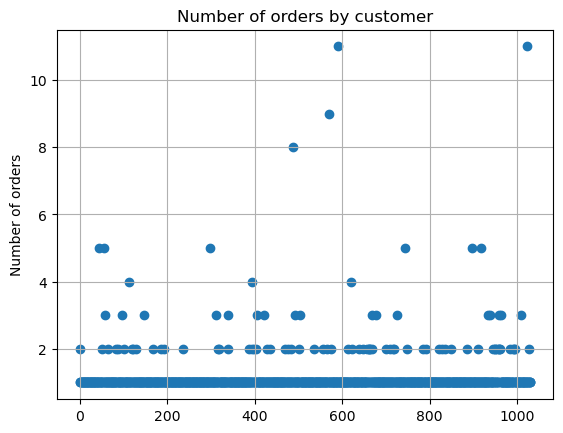

In [29]:
count_orders = orders.groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
point_orders = pd.Series(range(0, len(count_orders['transaction_id'])))

plt.scatter(point_orders, count_orders['transaction_id']);
plt.grid(True)
plt.ylabel("Number of orders")
plt.title('Number of orders by customer');

In [30]:
# calculation of 95th and 99th percentiles.
print(np.percentile(count_orders['transaction_id'], [95, 99]))

[2. 4.]


**Important!**

Since we will use this data to clean up outliers, let's see how orders will be distributed according to the data from the orders_clean table

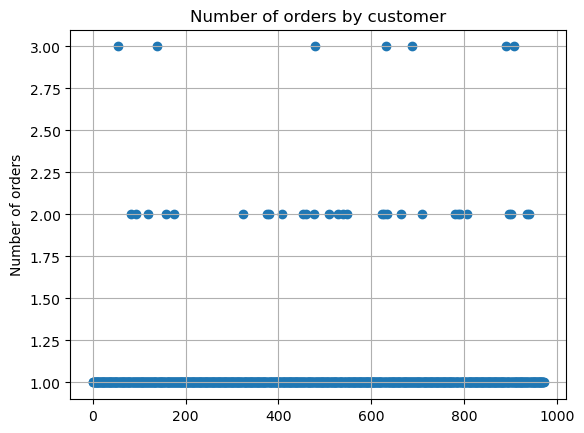

In [31]:
count_orders_clean = orders_clean.groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
point_orders_clean = pd.Series(range(0, len(count_orders_clean['transaction_id'])))

plt.scatter(point_orders_clean, count_orders_clean['transaction_id']);
plt.grid(True)
plt.ylabel("Number of orders")
plt.title('Number of orders by customer');

In [32]:
# calculation of 95th and 99th percentiles.
print(np.percentile(count_orders_clean['transaction_id'], [95, 99]))

[1. 2.]


`Notes`

- Data without overlapping customers showed that no more than 5% of people made more than 2 orders. All the anomalous orders we saw in the initial orders data are gone. That is why for further analysis we will take the value of the number of orders - no more than 2.

### Scatter plot of order values

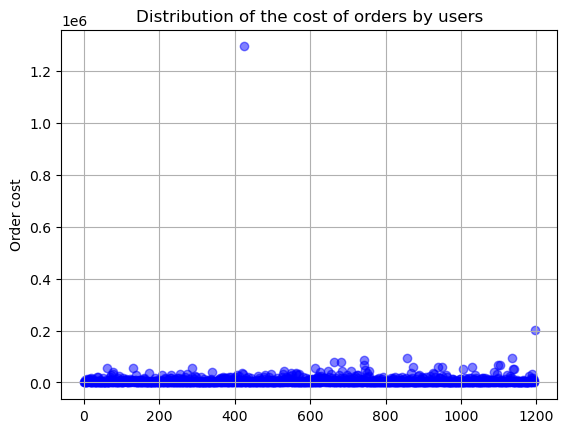

In [33]:
revenue_ = pd.Series(range(0, len(orders['revenue'])))

plt.scatter(revenue_, orders['revenue'], color='blue', alpha=0.5);
plt.grid(True)
plt.ylabel("Order cost")
plt.title('Distribution of the cost of orders by users');

In [34]:
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

`Notes`

- Almost all orders are up to 150 thousand. But there are two expensive orders that are not characteristic of the general group. Let's look at them, perhaps these are the "outliers" that prevented us from drawing conclusions about revenue and the average check.

In [35]:
orders[orders['revenue']>150000]

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B


`Notes`

- The anomalously expensive order of August 19 falls on group B. It was he who "spoiled" the revenue charts. The order dated August 15 also affected the results, but not as catastrophically as the order for 1.3 million rubles.

- Let's build a schedule without taking into account abnormal orders. And let's calculate the 95th and 99th percentiles to define the boundary for the anomalies.

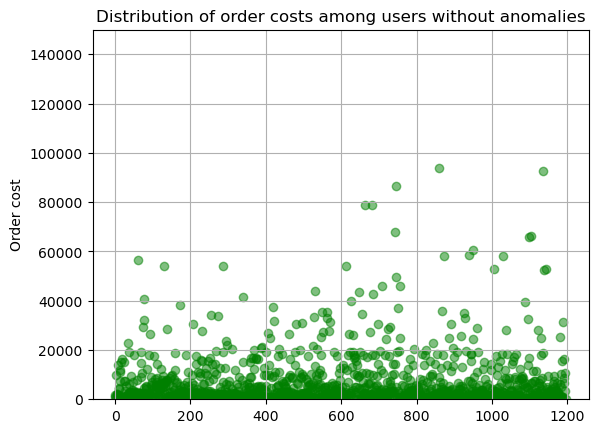

In [36]:
plt.ylim(0, 150000)
plt.scatter(revenue_, orders['revenue'], color='green', alpha=0.5)
plt.title('Distribution of order costs among users without anomalies')
plt.grid(True)
plt.ylabel("Order cost");

In [37]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Let's calculate the percentile for orders_clean.

In [38]:
print(np.percentile(orders_clean['revenue'], [95, 99])) 

[26785. 53904.]


`Notes`

For orders_clean, the order value for the 99th percentile decreased and amounted to 53,904 rubles. We will make this value the boundary for cutting off anomalies.

### Calculate the statistical significance of differences in the average number of orders per visitor.

In the calculation between groups A and B, we use "raw" data, including abnormal values for the number of orders and their amount.

Let's formulate hypotheses. Zero: There is no difference in the average number of orders between groups. Alternative: there are differences in the average between groups. Let's set p-value - 0.05.

In [39]:
# Create tables with the number of visitors for each unique day without accumulation for each group.
visitorsADaily = visitors[visitors['group'] == 'A'].rename(columns={'visitors': 'visitorsPerDateA'})[['date', 'visitorsPerDateA']]
visitorsBDaily = visitors[visitors['group'] == 'B'].rename(columns={'visitors': 'visitorsPerDateB'})[['date', 'visitorsPerDateB']]

# Let's create tables for each group, in which each unique customer will correspond to the number of purchases made by them.
ordersByUsersA = orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False)['transaction_id'].nunique().rename(columns={'transaction_id': 'orders'})
ordersByUsersB = orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False)['transaction_id'].nunique().rename(columns={'transaction_id': 'orders'})

Obviously, there are more visitors than buyers, so we need to add rows with zeros to the ordersByUsersA and ordersByUsersB tables, so that when calculating the average, the amount of orders is divided by the number of visitors.

In [40]:
# Calculate sample values of sampleA
sampleA = pd.concat([ordersByUsersA['orders'],
                      pd.Series(0, 
                                index=np.arange(visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), 
                                name='orders')], 
                     axis=0)

# Calculation of sample values of sampleB
sampleB = pd.concat([ordersByUsersB['orders'],
                      pd.Series(0, 
                                index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), 
                                name='orders')], 
                     axis=0)

# Output p-value calculated using the Mann-Whitney test
p_value = stats.mannwhitneyu(sampleA, sampleB)[1]
print("p-value: {0:.3f}".format(p_value))

# Display the relative difference between the means of two samples
relative_difference = sampleB.mean() / sampleA.mean() - 1
print("Relative difference between the average number of orders of group B to A: {0:.1f}%".format(relative_difference * 100))


p-value: 0.017
Relative difference between the average number of orders of group B to A: 13.8%


`Notes`
- When calculating the statistical significance of differences in the average number of orders per visitor between groups according to "raw" data, if the p-value is 0.05, then we can conclude that the differences between groups are statistically significant. In this case, the p-value is 0.017, which is less than 0.05, hence the null hypothesis is rejected. The null hypothesis was that there were no differences in the average number of orders between groups. And we have differences.

- In addition, the value of 13.8%, obtained from calculating the ratio of the average number of orders per visitor in group B to the average number of orders per visitor in group A, suggests that the number of orders in group B is 13.8% higher than in group A. We also saw this on the chart.

- For your information: the values in the orders_clean table are 0.011 and 16%, respectively. It does not fundamentally change anything, but in this variant group B is already 16% better than group A.

**Let's prove it by calculations on the table without intersecting orders orders_clean.**

In [41]:
# Let's create tables for each group, in which each unique customer will correspond to the number of purchases made by them.
ordersByUsersA_ = orders_clean[orders_clean['group'] == 'A'].groupby('visitor_id', as_index=False)['transaction_id'].nunique().rename(columns={'transaction_id': 'orders'})
ordersByUsersB_ = orders_clean[orders_clean['group'] == 'B'].groupby('visitor_id', as_index=False)['transaction_id'].nunique().rename(columns={'transaction_id': 'orders'})

# Calculate sample values of sampleA
sampleA_ = pd.concat([ordersByUsersA_['orders'],
                      pd.Series(0, 
                                index=np.arange(visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA_['orders'])), 
                                name='orders')], 
                     axis=0)

# Calculation of sample values of sampleB
sampleB_ = pd.concat([ordersByUsersB_['orders'],
                      pd.Series(0, 
                                index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB_['orders'])), 
                                name='orders')], 
                     axis=0)

# Output p-value calculated using the Mann-Whitney test
p_value = stats.mannwhitneyu(sampleA_, sampleB_)[1]
print("p-value: {0:.3f}".format(p_value))

# Display the relative difference between the means of two samples
relative_difference_ = sampleB_.mean() / sampleA_.mean() - 1
print("The relative difference between the average number of orders of group B to A: {0:.0f}%".format(relative_difference_ * 100))


p-value: 0.011
The relative difference between the average number of orders of group B to A: 16%


### We consider the statistical significance of differences in the average order receipt between groups according to "raw" data

Let's look at the statistical significance of the differences in the average check between A and B.

Null hypothesis: there are no differences in the average check between groups. Alternative hypothesis: there are differences in the average bill between groups. Let's set p-value - 0.05.

We will also find relative differences in the average check between groups:

In [42]:
print("p-value: {0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("Relative difference in the average check of group B to A: {0:.1f}%".format((orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)*100))

p-value: 0.729
Relative difference in the average check of group B to A: 25.9%


`Notes`

- The probability of obtaining differences (p-value) is higher than the given significance level (0.05), so we cannot reject the null hypothesis and conclude that there are statistically significant differences between the samples. There are no differences.

- In addition, the value of 25.9, obtained from calculating the ratio of the average check in group B to the average check in group A, indicates that the average check in group B is 25.9% higher than in group A. It is important to remember the "expensive" orders in group B here.

- For your information: the values in the orders_clean table are 0.829 and 28.7, respectively. There are no cardinal differences.

### We consider the statistical significance of differences in the average number of orders per visitor between groups according to the "cleaned" data

Previously, we defined what we would consider "outliers" for the number of orders per user 2 (99th percentile in the orders_clean table). For order value: 53904 (99th percentile for orders_clean).

Let's make cuts of users with more than 2 orders - order_big and users who have made orders more than 53904 - revenue_big. Let's combine them in the abnormal table.

In [43]:
order_big = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
revenue_big = orders[orders['revenue'] > 53904]['visitor_id']
abnormal = (
    pd.concat([order_big, revenue_big], axis=0)
    .drop_duplicates()
    .sort_values()
)

Let us calculate the statistical significance of differences in the average number of orders without abnormal values.

In the calculation between groups A and B, we use "cleaned" data, without abnormal values in terms of the number of orders and their amount.

Let's formulate hypotheses, they will be the same as for "raw" data. Our task is to understand how emissions affect the final result.

Null hypothesis: there is no difference in the average number of orders between groups. Alternative: there are differences in the average between groups. Let's set p-value - 0.05.

In [44]:
sampleA_clean = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitor_id'].isin(abnormal))]['orders'],pd.Series(0, index=np.arange(visitorsADaily['visitorsPerDateA'].sum()- len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB_clean = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitor_id'].isin(abnormal))]['orders'],pd.Series(0, index=np.arange(visitorsBDaily['visitorsPerDateB'].sum()- len(ordersByUsersA['orders'])), name='orders')],axis=0)

print("p-value: {0:.3f}".format(stats.mannwhitneyu(sampleA_clean, sampleB_clean)[1]))
print("Relative difference between the average value of the number of orders of group B to A: {0:.1f}%".format((sampleB_clean.mean()/sampleA_clean.mean()-1)*100))

p-value: 0.012
Relative difference between the average value of the number of orders of group B to A: 16.9%


`Notes`

- Statistically significant decreased slightly compared to calculations with "outliers" taken into account. Thus, the differences between the groups are still statistically significant. We reject the null hypothesis.

- The ratio of average bookings per visitor in Group B to average bookings per visitor in Group A increased by almost 3 percent. This means that the relative differences in the average number of orders in group B on cleaned data without anomalies are 16.9% higher than in group A.

- For your information: the values in the orders_clean table are 0.009 and 0.184, respectively. There are no cardinal differences.

### Calculate the statistical significance of differences in the average order receipt between groups without taking into account anomalies

Let's look at the statistical significance of the differences in the average check between A and B on the data without anomalies.

Null hypothesis: there are no differences in the average check between groups. Alternative hypothesis: there are differences in the average bill between groups. Let's set p-value - 0.05.

We will also find relative differences in the average check between groups:

In [45]:
print("p-value {0:.3f}".format(
    stats.mannwhitneyu(
        orders[np.logical_and(
            orders['group'] == 'A',
            np.logical_not(orders['visitor_id'].isin(abnormal))
        )]['revenue'],
        orders[np.logical_and(
            orders['group'] == 'B',
            np.logical_not(orders['visitor_id'].isin(abnormal))
        )]['revenue']
    )[1]
))


print("Relative difference in the average check of group B to A:{0:.0f}%".format((
    orders[np.logical_and(
        orders['group'] == 'B',
        np.logical_not(orders['visitor_id'].isin(abnormal))
    )]['revenue'].mean() / orders[np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitor_id'].isin(abnormal))
    )]['revenue'].mean() - 1
)*100))

p-value 0.798
Relative difference in the average check of group B to A:-2%


The value of 0.798 tells us that there is no statistically significant difference in the average check between the groups. We confirm the null hypothesis.

A value of -2%, on the other hand, indicates that the average check of group B is slightly less than that of group A, by 2%.

`Notes`

- Thus, we can conclude that there is no statistically significant difference in the average check between groups A and B, except for a small difference of 2%. However, this small difference can be of practical importance if it is multiplied by a large number of orders.

### General conclusion:

1. Prioritization of hypotheses.

It is recommended to be guided by the results of hypotheses prioritization based on the RICE method.
Top three hypotheses:
- Add a subscription form to all main pages to build a customer base for email newsletters
- Add product recommendation blocks to the online store website to increase conversion and average check of the order
- Add two new channels to attract traffic, which will attract 30% more users

2. A / B test.

It is recommended that the test be stopped and, with great caution, group B be declared the winner if this is acceptable only on the basis that the average number of orders in group B is 16.9% higher than group A.
It is important to note that group B is inferior to group A in terms of the size of the average check. Check B is relatively less than A by 2%. This means that as a result of the test, the average check in group B decreased.

Probably, such a test result appeared due to incorrect input data: overlapping orders in groups, which in total accounted for more than 15% of revenue for the test period, and the lack of data on unique visitors, which also prevents a correct comparison of the average number of orders for each group.